# Table of Contents

1. [Summary](#1.-Summary) <br>
2. [Introduction](#2.-Introduction) <br>
    2.1. [Data preparation](#2.1.-Data-preparation) <br>
3. [Feature extraction](#3.-Feature-extraction) <br>
4. [Exploratory Data Analysis](#4.-Exploratory-Data-Analysis) <br>
    4.1. [Data size and structure](#4.1.-Data-size-and-structure) <br>
    4.2. [Variables exploration](#4.2.-Variables-exploration) <br>
      ..4.2.1. [Target](#4.2.1.-Target) <br>
      ..4.2.2. [Continuous features](#4.2.2.-Continuous-features) <br>
      ..4.2.3. [Categorical features](#4.2.3.-Categorical-features) <br>
      ..4.2.4. [Features combined](#4.2.4.-Features-combined) <br>
      ..4.2.5. [Extracurricular features](#4.2.5.-Extracurricular-features) <br>
      ..4.2.6. [Dependencies](#4.2.6.-Dependencies) <br>
5. [Outliers](#5.-Outliers) <br>
    5.1. [Temperature](#5.1.-Temperature) <br>
    5.2. [Humidity](#5.2.-Humidity) <br>
6. [Feature engineering](#6.-Feature-engineering) <br>
7. [Preprocessing](#7.-Preprocessing) <br>
    7.1. [Train test split](#7.1.-Train-test-split) <br>
    7.2. [Preprocess pipeline](#7.2.-Preprocess-pipeline) <br>
    7.3. [Correlation matrix](#7.3.-Correlation-matrix) <br>
8. [Modeling](#8.-Modeling) <br>
    8.1. [RMSE](#8.1.-RMSE) <br>
    8.2. [Linear regression](#8.2.-Linear-regression) <br>
    8.3. [Extra-Tree](#8.4.-Extra-Tree) <br>
    8.4. [XGBoost](#8.4.-XGBoost) <br>
      ..8.4.1. [Training](#8.4.1.-Training) <br>
9. [Interpretation](#9.-Interpretation) <br>
10. [Prediction](#10.-Prediction) <br>
11. [Best model](#11.-Best-model) <br>
12. [Room for improvement](#12.-Room-for-improvement) <br>

# 1. Summary

I started building the model from a good acquaintance with the available data. The detailed EDA with numerous visualizations is below. At the end of the notebook construction of predictive models was made.

* The XGBoost model performs best with a final RMSE of 0.42965.
* Ridge and Lasso regression was also tested but their results were significantly worse than the result of xgboost therefore several models were not averaged.
* Also Extra-Randomized-Trees have been tried with a best cross-validation RMSE of 0.45969.
* All hyperparameters were tuned by means of bayesian-optimization.


# 2. Introduction

This notebook is the solution to the "Bike Sharing Demand" competition organized on the Kaggle platform. Detailed information can be found under the [attached link](https://www.kaggle.com/c/bike-sharing-demand).

## 2.1. Data preparation

In this step I load the libraries that I will use throughout this project as well as read the train and test sets to pandas dataframes. I also change the name of the target variable to "target" because the previous name could be misleading.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import xgboost as xgb

from functools import reduce
from collections import Counter
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge
from scipy.stats import probplot
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours, load_logs
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from xgboost import XGBRegressor

from paralytics.utils.plotting import multipleplots, plot_learning_curve
from paralytics.mathy import custom_round
from paralytics.column_parsing import CategoricalGrouper, ColumnProjector, TypeSelector, ColumnSelector
from paralytics.encoding import TargetEncoder
from paralytics.collinearity_reduction import VIFSelector


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('ticks')
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

We can see that "casual" and "registered" variables are not provided in the test set (if so, then predicting the total number of rented bikes would be much easier I suppose). However, we will leave them only for the sake of satisfying the curiosity about the distribution of rentals between registered and unregistered users and only after that those variables will be dropped.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Renaming target variable for better readability.
df_train.rename(columns={'count': 'target'}, inplace=True)

# Combining train with test to make simultaneous transformations unless it is related 
# to information leakage.
df = pd.concat(objs=[df_train, df_test], axis=0, sort=False).reset_index(drop=True)

# Condition for selecting training instances.
tr_cond = ~df.target.isnull()

df_train = df[tr_cond]
df_test = df[~tr_cond].reset_index(drop=True)

# 3. Feature extraction

Inside the "datetime" variable there are many features hidden that may prove to be crucial for predicting the number of rented bikes, for example: the day of the week, month and hour. Let's extract them.

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['hour'] = df.datetime.dt.hour
df['weekday'] = df.datetime.dt.weekday
df['day'] = df.datetime.dt.day
df['month'] = df.datetime.dt.month
df['year'] = df.datetime.dt.year

df['weekday'] = df['weekday'].map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 
                                   4: 'Fri', 5: 'Sat', 6: 'Sun'})

df.drop('datetime', axis=1, inplace=True)

df = df[[col for col in df if col not in ['casual', 'registered', 'target']] 
        + ['casual', 'registered', 'target']]

df_train = df[tr_cond]
df_test = df[~tr_cond].reset_index(drop=True)

# 4. Exploratory Data Analysis

## 4.1. Data size and structure

In the further part all statistics as well as variable analysis will be carried out only on the training set.

From the basic statistics below we can see that standard deviation for "holiday" variable is relatively low. There is no surprise because the holidays are quite occasional. It was quite important to check because I wasn't sure whether Sundays are treated as a holiday. For my surprise there is significant advantage in rentals on the part of registered users (on average 4 times more rented bikes). It may have a connection with loyalty systems run for registered clients.

In [4]:
df_train.iloc[24:32]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,day,month,year,casual,registered,target
24,1,0,0,2,18.86,22.725,88,19.9995,0,Sun,2,1,2011,4.0,13.0,17.0
25,1,0,0,2,18.04,21.970,94,16.9979,1,Sun,2,1,2011,1.0,16.0,17.0
26,1,0,0,2,17.22,21.210,100,19.0012,2,Sun,2,1,2011,1.0,8.0,9.0
27,1,0,0,2,18.86,22.725,94,12.9980,3,Sun,2,1,2011,2.0,4.0,6.0
28,1,0,0,2,18.86,22.725,94,12.9980,4,Sun,2,1,2011,2.0,1.0,3.0
29,1,0,0,3,17.22,21.210,77,19.9995,6,Sun,2,1,2011,0.0,2.0,2.0
30,1,0,0,2,16.40,20.455,76,12.9980,7,Sun,2,1,2011,0.0,1.0,1.0
31,1,0,0,3,16.40,20.455,71,15.0013,8,Sun,2,1,2011,0.0,8.0,8.0


2011-01-02 was Sunday and we can see that the value of the variable holiday is equal to 0.

In [5]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,casual,registered,target
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,11.541613,9.992559,6.521495,2011.501929,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,6.915838,5.476608,3.444373,0.500019,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,6.000000,5.000000,4.000000,2011.000000,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,12.000000,10.000000,7.000000,2012.000000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,18.000000,15.000000,10.000000,2012.000000,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,23.000000,19.000000,12.000000,2012.000000,367.000000,886.000000,977.000000


Interestingly minimum value of the target variable is 1. It implies that:
* at every time at least one bicycle is rented, or
* hours when there was no rental done were dropped from the dataset

Let's investigate it.

In [6]:
g_train = df_train.groupby(['day', 'month', 'year']).agg('count').season
g_test = df_test.groupby(['day', 'month', 'year']).agg('count').season
missing_g_train = g_train[g_train < 24]
missing_g_test = g_test[g_test < 24]
print(f'Number of days in the train set with at least one hour missing: {len(missing_g_train)} \n'
      f'Number of days in the test set with at least one hour missing: {len(missing_g_test)}')

Number of days in the train set with at least one hour missing: 42 
Number of days in the test set with at least one hour missing: 34


Ok, based on the deficiencies in the train and test sets I conclude that this is due to a drop from those sets hours without bike rentals. To be sure, let's check in what hours there were such missings.

In [7]:
def normed_sum(series):
    return sum(range(24)) - reduce(lambda x, y: x + y, series)

missing_train = missing_g_train.reset_index().drop('season', axis=1)
missing_test = missing_g_test.reset_index().drop('season', axis=1)

keys = missing_test.columns.tolist()
i1 = df_test.set_index(keys).index
i2 = missing_test.set_index(keys).index
missing_hours_test = Counter(df_test[i1.isin(i2)].groupby(['day', 'month', 'year']).agg(normed_sum).hour.tolist())

keys = missing_train.columns.tolist()
i1 = df_train.set_index(keys).index
i2 = missing_train.set_index(keys).index
missing_hours_train = Counter(df_train[i1.isin(i2)].groupby(['day', 'month', 'year']).agg(normed_sum).hour.tolist())

print('Missing hours (key) in the train set with its number of occurences (value): \n', missing_hours_train, 
      '\nMissing hours (key) in the test set with its number of occurences (value): \n', missing_hours_test)

Missing hours (key) in the train set with its number of occurences (value): 
 Counter({3: 17, 4: 9, 2: 6, 5: 4, 7: 4, 1: 1, 66: 1}) 
Missing hours (key) in the test set with its number of occurences (value): 
 Counter({4: 13, 5: 5, 3: 5, 2: 2, 6: 2, 15: 1, 130: 1, 120: 1, 123: 1, 21: 1, 276: 1, 78: 1})


Now hypothesis is confirmed. We can clearly see that missing hours are the night hours (mainly from 2 to 6 am). Occasionally the greater part of the day was without a rental, probably caused by service works.

While looking at the data I have also discovered appearing large differences between temp and atemp in some cases. Attention is drawn to the fact that in the case of deviating measurements, the "atemp" value most often repeats itself. I will keep it in mind for later.

In [8]:
atemp_df = df_train[abs(df_train.temp - df_train.atemp) > 5].atemp.value_counts()

print(f'Most repeated "atemp" values: {atemp_df.index[:3].tolist()} '
      f'and their count numbers: {atemp_df.iloc[:3].tolist()}.')

Most repeated "atemp" values: [31.06, 34.85, 36.365] and their count numbers: [286, 89, 54].


In [9]:
print("Variables' types: ")
df_train.dtypes

Variables' types: 


season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
hour            int64
weekday        object
day             int64
month           int64
year            int64
casual        float64
registered    float64
target        float64
dtype: object

## 4.2. Variables exploration

### 4.2.1. Target

Submissions will be evaluated on the Root Mean Squared Logarithmic Error thus it is reasonable to transform our target variable with natural logarithm of target + 1 (+1 prevents taking logarithm of 0).

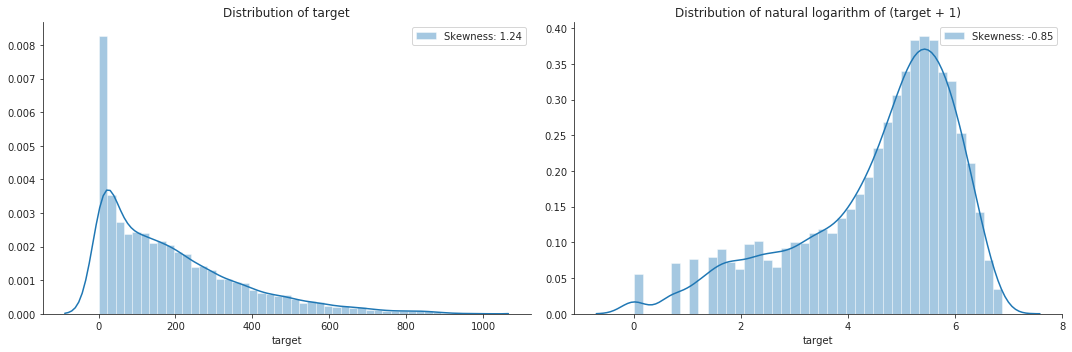

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1 = sns.distplot(df_train.target, ax=ax1, label='Skewness: %.2f' % (df_train.target.skew()))
ax1.legend()
ax1.set_title('Distribution of target')

ax2 = sns.distplot(np.log(df_train.target), ax=ax2, label='Skewness: %.2f' % (np.log(df_train.target+1).skew()))
ax2.legend()
ax2.set_title('Distribution of natural logarithm of (target + 1)')
sns.despine()
plt.tight_layout()
plt.show()

### 4.2.2. Continuous features

As we can see only windspeed variable is significantly right skewed. It was expected because strong winds are rather rare, and windless weather is definitely more common.

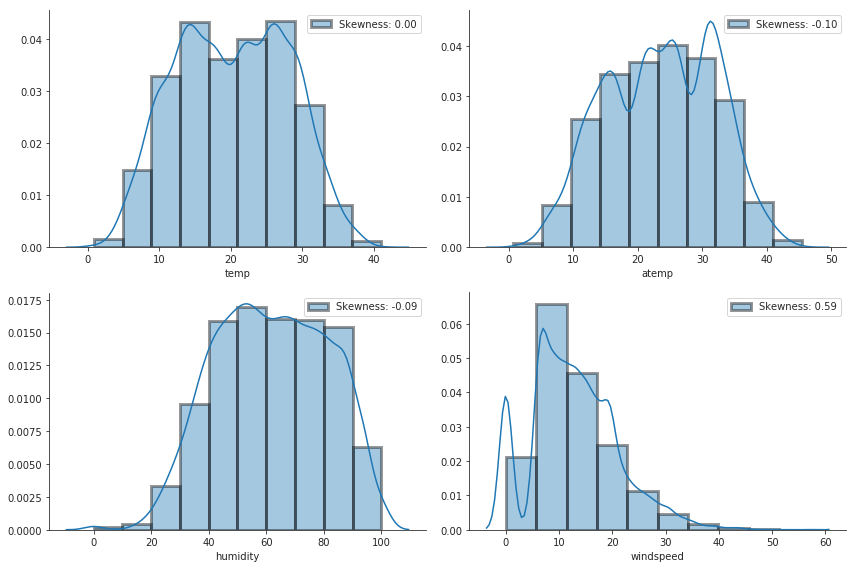

In [11]:
continuous_feat = ['temp', 'atemp', 'humidity', 'windspeed']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    plt.sca(ax)
    current_series = df_train[continuous_feat[idx]]
    ax = sns.distplot(current_series, bins=10, hist_kws={'edgecolor': 'black', 'linewidth': 3},
                      label=f'Skewness: {current_series.skew():.2f}')
    ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

Let's check for outliers in the continuous variables set. It's worth that during the considered period a few very dry days took place and dozen when gale was recorded. We will give it further inspection in a few moments. It is important to remember that we do not necessarily deal with a Gaussian distribution, which implies that our definition of an outlier, based on the **IQR rule** where we suppose that values bigger than $Q_3 + 1.5\cdot IQR$ or smaller than $Q_1 - 1.5\cdot IQR$ are identified with outliers, may be incorrect.



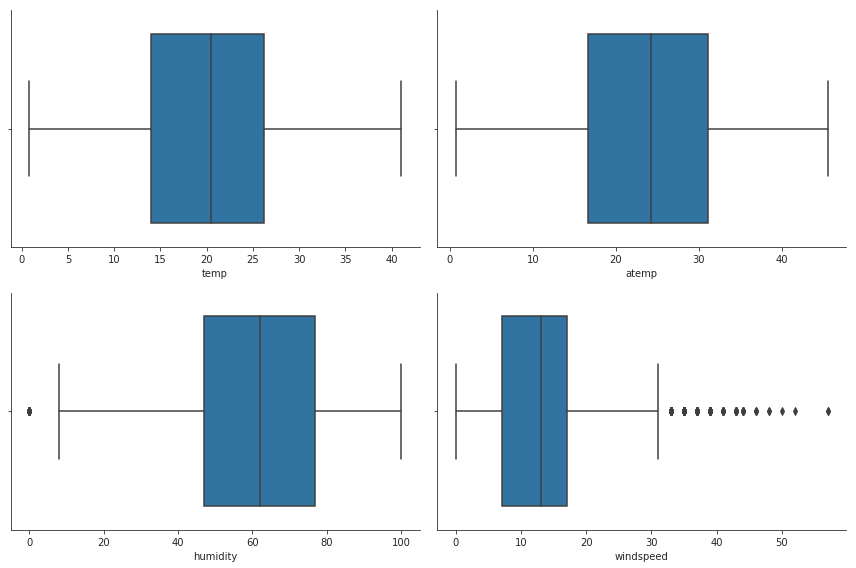

In [12]:
multipleplots(x=continuous_feat, data=df_train, nrows=2, ncols=2, figsize=(12, 8), plot_type='boxplot')
sns.despine()
plt.tight_layout()
plt.show()

Lastly we will observe dependencies between continuous variables and the target variable. According to suspicion, more humidity affects the smaller number of rented bikes, just as low temperature.

supposedly it will be advisable to remove one of the features related to temperature because their relation to the target variable is almost identical thus it will turn to be a multicollinearity.

Interesting phenomenon is observable in the case of wind where a lot of 0's were recorded at the same time not recording measurements smaller than ~5 at all. It can be noticed that the measurements are recorded at certain intervals so probably due to the lack of accuracy, extreme (mainly minimal) speeds were not observed and filled with 0's. 

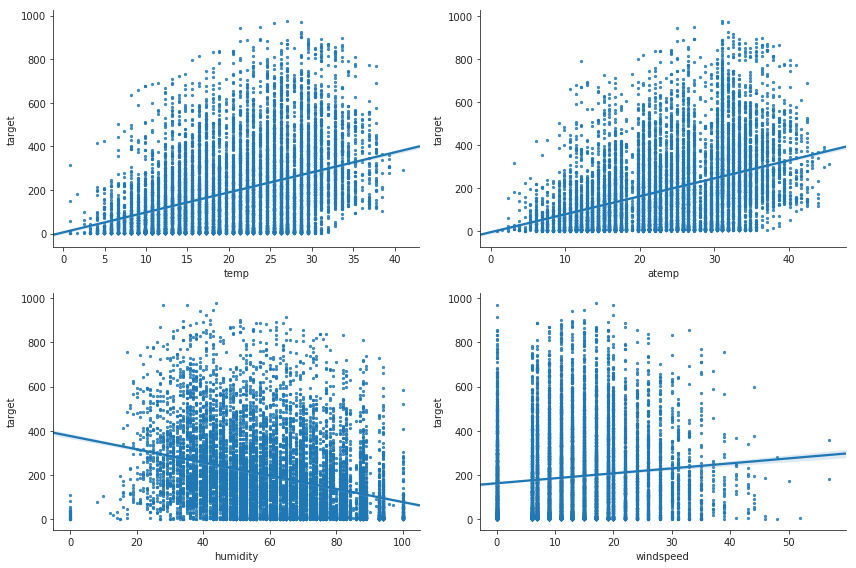

In [13]:
multipleplots(x=continuous_feat, data=df_train, nrows=2, ncols=2, figsize=(12, 8), 
              plot_type='regplot', y='target', scatter_kws={'s': 5})
sns.despine()
plt.tight_layout()
plt.show()

#### Humidity

In our data we have recorded a few dry days. We will check whether they were actually hot summer days, or maybe missing filled with 0's.

In [14]:
df_train[df_train.humidity == 0].groupby(['day', 'month', 'year']).agg('sum')

,,,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,casual,registered,target
day,month,year,,,,,,,,,,,,
10,3,2011,22,0,22,64,350.96,424.235,0,386.0071,269,46.0,577.0,623.0


We can see it was only one spring dry day so we will leave it as it is.

#### Windspeed

We can see that distances between successive measurements are almost the same and mainly they are equal to 1 or 2 so in the next stage they will most likely be rounded and projected onto integers.

In [15]:
smaller_windspeed = min(df_train[df_train.windspeed != 0].windspeed)
print(f'Smaller not 0 windspeed: {smaller_windspeed}\n')

unique_windspeed = df_train.windspeed.unique()
unique_windspeed.sort()
print('Unique windspeed values: \n', unique_windspeed)

Smaller not 0 windspeed: 6.0032

Unique windspeed values: 
 [ 0.      6.0032  7.0015  8.9981 11.0014 12.998  15.0013 16.9979 19.0012
 19.9995 22.0028 23.9994 26.0027 27.9993 30.0026 31.0009 32.9975 35.0008
 36.9974 39.0007 40.9973 43.0006 43.9989 46.0022 47.9988 50.0021 51.9987
 56.9969]


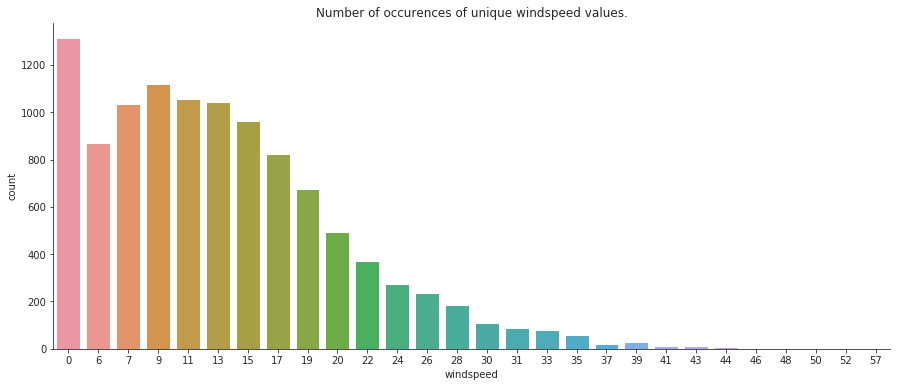

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.countplot(x='windspeed', ax=ax, data=df_train)
ax.set_title('Number of occurences of unique windspeed values.')
ax.set_xticklabels('{:.0f}'.format(label) for label in unique_windspeed)
sns.despine()
plt.show()

As we can see outlying observations from the first 0's group suggests that it is the group of wind speeds that the measuring device was not able to cover. We will keep this in mind and later decide whether transform those observations (counting it as NaNs) or leave it as it is (believing those observations are in the [0, 6] interval).

### 4.2.3. Categorical features

Let's now take a closer look at the categorical features. We will try to visualize their impact on the dependent variable with use of boxplots.

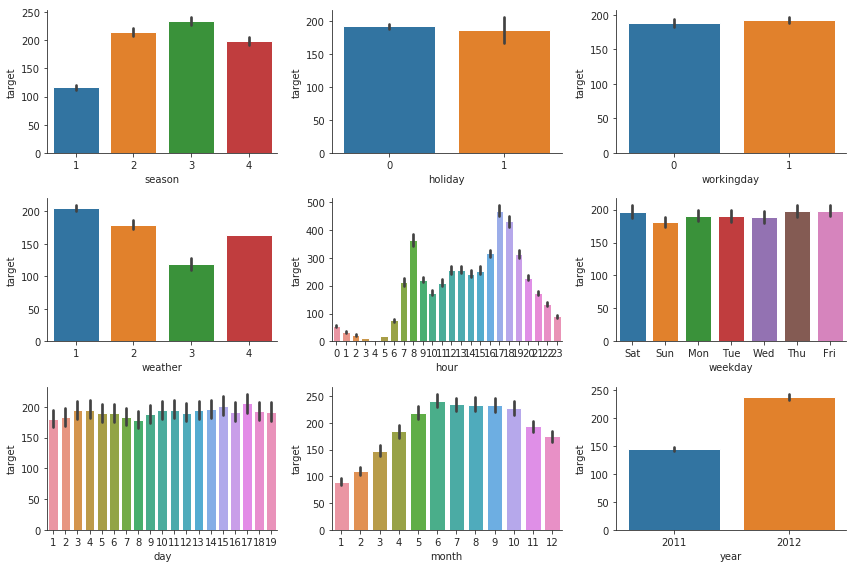

In [17]:
categorical_feat = [col for col in df_train.columns if col not in continuous_feat 
                                                                  + ['target', 'casual', 'registered']]

multipleplots(data=df_train, x=categorical_feat, y='target', nrows=3, ncols=3, figsize=(12, 8), 
              plot_type='barplot')
sns.despine()
plt.tight_layout()
plt.show()

From the above charts, it can be assumed that the variables that make the segmentation into the number of bike rentals can be:
* year: in 2012, definitely more bikes were rented than in the previous year,
* month: in winter the number of rentals is definitely lower than in other seasons,
* hour: during peak hours (before and after work), the number of rentals is the highest,
* weather: the worse the weather, the less you rent,
* season: same as month, thus highly correlated.

Let's get a more detailed analysis of these variables.

#### Year and month

This variable "year" is almost self explanatory - the more recent year was the year of prosperity, so the only thing will be to confront the distributions of rentals over months in those years.

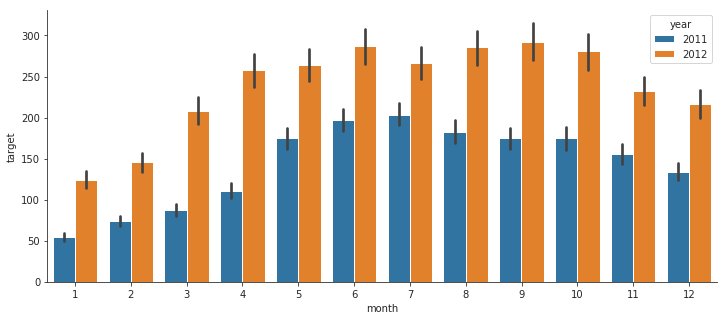

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=df_train, x='month', y='target', hue='year', ax=ax)
sns.despine()
plt.show()

#### Weather

It seems strange that the number of rental bikes in the worst weather scenario was on average higher than in a slightly better case. After investigation we can see that this was dictated by the insufficient number of observations for this category, especially that the event took place at 18, when people who have already arrived on a bike to work, had to somehow return home, which explains the high number of rents. Therefore, it will be rational to combine the 3rd and 4th categories in the next step.

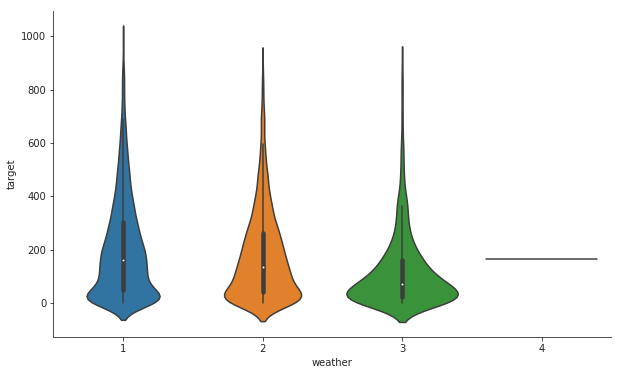

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,day,month,year,casual,registered,target
5631,1,0,1,4,8.2,11.365,86,6.0032,18,Mon,9,1,2012,6.0,158.0,164.0


In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.violinplot(x='weather', y='target', ax=ax, data=df_train)
sns.despine()
plt.show()

df_train[df_train.weather == 4]

#### Season

Documentation to the given competition states that season 1 stands for spring but we can clearly see that season 1 correpsonds to winter, 2 to spring, etc. That being said we can see the distributions of this feature.

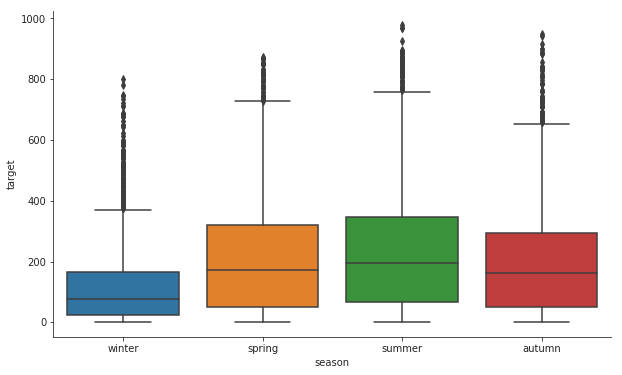

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x='season', y='target', ax=ax, data=df_train)
ax.set_xticklabels(['winter', 'spring', 'summer', 'autumn'])
sns.despine()
plt.show()

#### Hour

Looking only at the hours we can see the peak at 8 and 16-18 but we are almost certain that it is caused by people commuting or leaving work. You can expect that during day off this target distribution will be more smooth, spreading out throughout the day. Let's check that intuition.

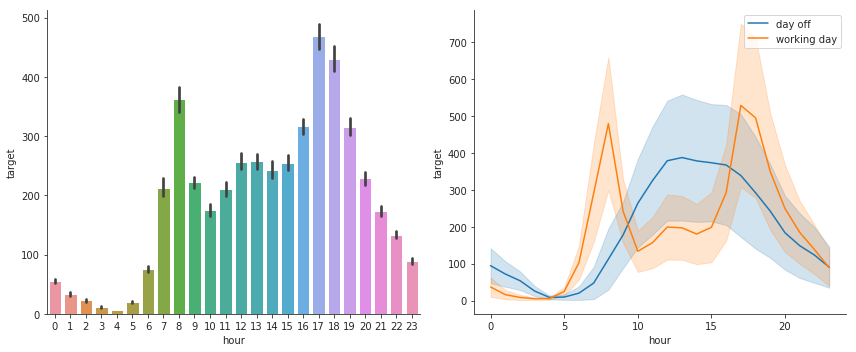

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()
axes[0] = sns.barplot(x='hour', y='target', data=df_train, ax=axes[0])
g = sns.relplot(x='hour', y='target', hue='workingday', kind='line', ci='sd', data=df_train, legend=False, ax=axes[1])
plt.close(g.fig)
axes[1].legend(['day off', 'working day'])
sns.despine()
plt.tight_layout()
plt.show()

### 4.2.4. Features combined

Dividing the target variable depending on the temperature and the year we can clearly see the previously confirmed thesis, that the second year was more profitable in terms of rental, as well as that the weather has a significant impact on their total number. It is also noteworthy that people below a certain temperature are not willing to rent bicycles (the weather is a big factor in the demand for cycling).

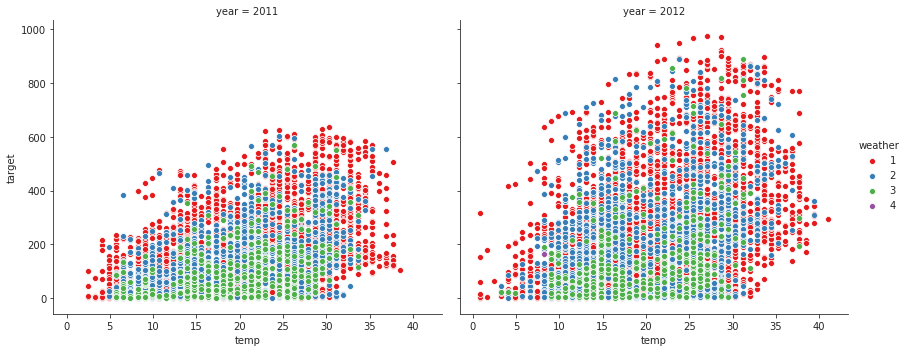

In [22]:
g = sns.FacetGrid(data=df_train, col='year', hue='weather', palette='Set1', height=5, aspect=1.2)
g = (g.map(sns.scatterplot, 'temp', 'target', edgecolor="w").add_legend())

### 4.2.5. Extracurricular features

#### casual and registered

Registered clients constituted the bigger part of the rentals among given years. There is also a considerable increase in the number of rentals over those years. The seasonal effect is also noticeable.

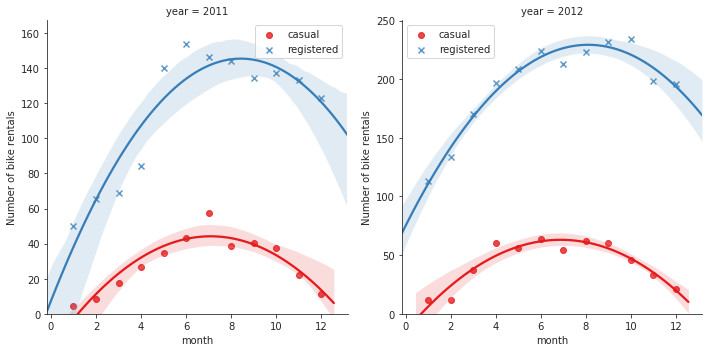

In [23]:
tab = df_train.groupby(['month', 'year']).agg('mean')[['casual', 'registered']].reset_index()
tab = pd.melt(tab, id_vars=['month', 'year'], value_vars=['casual', 'registered'])
lm = sns.lmplot(x='month', y='value', hue='variable', markers=['o', 'x'], col='year', order=2, data=tab, 
                sharex=False, sharey=False, legend=False, palette='Set1')
axes = lm.axes.flatten()
axes[0].set_ylabel('Number of bike rentals')
axes[0].set_ylim(0, )
axes[0].legend()
axes[1].set_ylabel('Number of bike rentals')
axes[1].set_ylim(0, )
axes[1].legend()
plt.tight_layout()
plt.show()

### 4.2.6. Dependencies

Let's investigate dependencies between our continuous variables first. We can clearly see that for outlying "atemp" values of around 12, temperature measurements from a quite wide range are assigned. I was already paying attention to this before and I think that it will be the most reliant to replace these values with the actual temperature. High correlation between "atemp" and "temp" was also mentioned before and now it is just proven one more time. Among remaining pairs of variables the correlation can not be determined (which does not necessarily imply the independence of these variables).

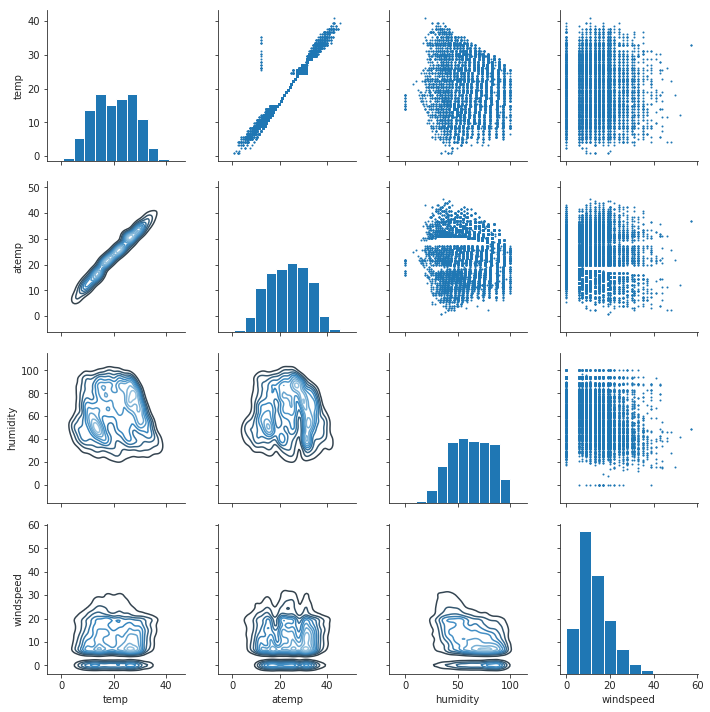

In [24]:
g = sns.PairGrid(data=df_train, vars=continuous_feat)
g = g.map_lower(sns.kdeplot, cmap='Blues_d')
g = g.map_diag(plt.hist, edgecolor='w')
g = g.map_upper(plt.scatter, s=1, cmap='Blues_d')

# 5. Outliers

## 5.1. Temperature

In the Exploratory Data Analysis we managed to find some outlying values for "atemp" feature in relation to the actual temperature. I would like to look closer to those instances.

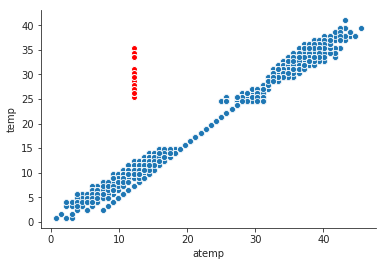

In [25]:
outlier_cond = abs(df_train.atemp - df_train.temp) > 10

fig, ax = plt.subplots()
ax = sns.scatterplot(df_train.atemp[~outlier_cond], df_train.temp[~outlier_cond], ax=ax)
ax = ax.scatter(df_train.atemp[outlier_cond], df_train.temp[outlier_cond], marker='o', color='r', edgecolor='w')
sns.despine()
plt.show()

Let's select those rows where the absolute difference between "feels like" temperature and actual temperature is greater than 10.

We can see that it was only one autumn day when those deviations where noticed. This day was windless almost entirely, the weather was great (assigned to the first category), all indications are that it is a measurement error that's why we'll replace those values with the temperature value rounded to the closest so far recorded "feels like" temperature.

In [26]:
temp_outliers_idx = df_train[outlier_cond].index
df.iloc[temp_outliers_idx]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,day,month,year,casual,registered,target
8991,3,0,1,1,27.88,12.12,57,11.0014,0,Fri,17,8,2012,21.0,67.0,88.0
8992,3,0,1,1,27.06,12.12,65,7.0015,1,Fri,17,8,2012,16.0,38.0,54.0
8993,3,0,1,1,27.06,12.12,61,8.9981,2,Fri,17,8,2012,4.0,15.0,19.0
8994,3,0,1,1,26.24,12.12,65,7.0015,3,Fri,17,8,2012,0.0,6.0,6.0
8995,3,0,1,1,26.24,12.12,73,11.0014,4,Fri,17,8,2012,0.0,9.0,9.0
8996,3,0,1,1,26.24,12.12,73,7.0015,5,Fri,17,8,2012,2.0,34.0,36.0
8997,3,0,1,1,25.42,12.12,78,8.9981,6,Fri,17,8,2012,6.0,151.0,157.0
8998,3,0,1,1,26.24,12.12,73,7.0015,7,Fri,17,8,2012,11.0,368.0,379.0
8999,3,0,1,1,27.88,12.12,65,8.9981,8,Fri,17,8,2012,43.0,625.0,668.0
9000,3,0,1,1,28.70,12.12,58,7.0015,9,Fri,17,8,2012,58.0,320.0,378.0


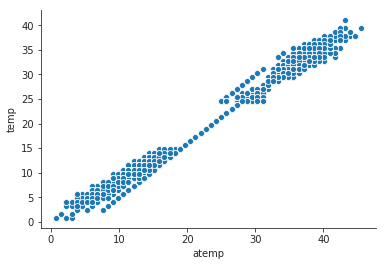

In [27]:
unique_atemp = df_train.atemp.unique().tolist()
df.loc[temp_outliers_idx, 'atemp'] = df.loc[temp_outliers_idx, 'temp'].apply(lambda x: custom_round(unique_atemp, x))

# Updating the train and test set.
df_train = df[tr_cond]
df_test = df[~tr_cond].reset_index(drop=True)

# Double checking.
sns.scatterplot(df_train.atemp, df_train.temp)
sns.despine()
plt.show()

## 5.2. Humidity

Humidity is also suspicious. We can see that some 0's were recorded in the training data that are not easy to explain by another variable. Let's visualize those instances below. We can clearly see that this day was probably a bit snowy judging by the prism of actual season (winter). Zero humidity when snow is falling is rather impossible so we need to impute this value one more time. We will do that with use of a simple non-parametric regression model.

In [28]:
outlier_cond = df_train.humidity == 0
df.iloc[df_train[outlier_cond].index]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,day,month,year,casual,registered,target
1091,1,0,1,3,13.94,15.910,0,16.9979,0,Thu,10,3,2011,3.0,0.0,3.0
1092,1,0,1,3,13.94,15.910,0,16.9979,1,Thu,10,3,2011,0.0,2.0,2.0
1093,1,0,1,3,13.94,15.910,0,16.9979,2,Thu,10,3,2011,0.0,1.0,1.0
1094,1,0,1,3,14.76,17.425,0,12.9980,5,Thu,10,3,2011,1.0,2.0,3.0
1095,1,0,1,3,14.76,16.665,0,22.0028,6,Thu,10,3,2011,0.0,12.0,12.0
1096,1,0,1,3,15.58,19.695,0,15.0013,7,Thu,10,3,2011,1.0,36.0,37.0
1097,1,0,1,3,15.58,19.695,0,19.0012,8,Thu,10,3,2011,1.0,43.0,44.0
1098,1,0,1,3,16.40,20.455,0,15.0013,9,Thu,10,3,2011,1.0,23.0,24.0
1099,1,0,1,3,16.40,20.455,0,11.0014,10,Thu,10,3,2011,0.0,17.0,17.0
1100,1,0,1,3,16.40,20.455,0,16.9979,11,Thu,10,3,2011,6.0,5.0,11.0


Humidity skewness is negligibly small so we will fit the RandomForest on the standard 'mse' criterion. Date as well as holidays or days off should not affect the humidity so we will stick to only a few variables. We can also observe that all of our missings are in winter so it will do the segmentation for our training data and we will limit to train only on the winter instances.

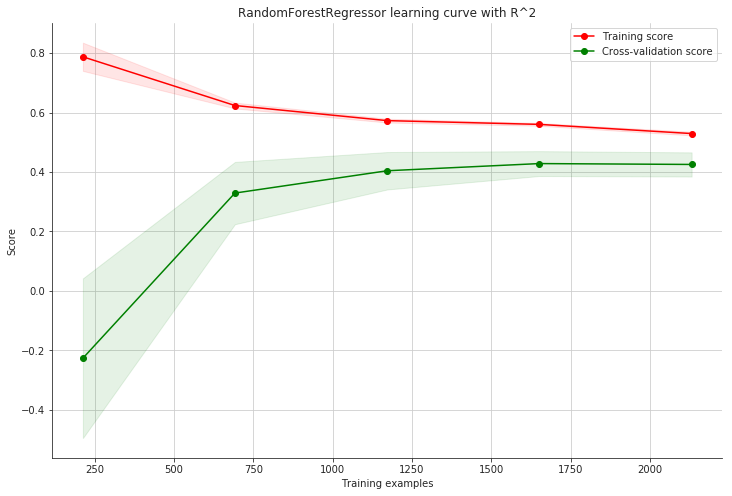

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,day,month,year,casual,registered,target
1091,1,0,1,3,13.94,15.910,82,16.9979,0,Thu,10,3,2011,3.0,0.0,3.0
1092,1,0,1,3,13.94,15.910,82,16.9979,1,Thu,10,3,2011,0.0,2.0,2.0
1093,1,0,1,3,13.94,15.910,81,16.9979,2,Thu,10,3,2011,0.0,1.0,1.0
1094,1,0,1,3,14.76,17.425,85,12.9980,5,Thu,10,3,2011,1.0,2.0,3.0
1095,1,0,1,3,14.76,16.665,75,22.0028,6,Thu,10,3,2011,0.0,12.0,12.0
1096,1,0,1,3,15.58,19.695,80,15.0013,7,Thu,10,3,2011,1.0,36.0,37.0
1097,1,0,1,3,15.58,19.695,78,19.0012,8,Thu,10,3,2011,1.0,43.0,44.0
1098,1,0,1,3,16.40,20.455,81,15.0013,9,Thu,10,3,2011,1.0,23.0,24.0
1099,1,0,1,3,16.40,20.455,82,11.0014,10,Thu,10,3,2011,0.0,17.0,17.0
1100,1,0,1,3,16.40,20.455,78,16.9979,11,Thu,10,3,2011,6.0,5.0,11.0


In [29]:
humidity_cols = ['weather', 'temp', 'atemp', 'windspeed', 'hour']
humi_train = df_train[(~outlier_cond) & (df_train.season == 1)][humidity_cols].reset_index(drop=True)
humi_y_train = df_train[(~outlier_cond) & (df_train.season == 1)]['humidity'].reset_index(drop=True)

humi_test = df_train[outlier_cond][humidity_cols].reset_index(drop=True)

params = {
    'n_estimators': [5 * n for n in range(2, 6)],
    'max_depth': list(range(2, 6)),
    'max_features': list(range(1, 6))
}

gscv = GridSearchCV(RandomForestRegressor(random_state=SEED), params, cv=5)
gscv.fit(humi_train, humi_y_train)

plot_learning_curve(gscv.best_estimator_, 'RandomForestRegressor learning curve with R^2', 
                    humi_train, humi_y_train, cv=5)
sns.despine()
plt.show()

df.loc[df_train[outlier_cond].index, 'humidity'] = np.round(gscv.predict(humi_test), 0).astype(int)
df.iloc[df_train[outlier_cond].index]

The results are satisfactory because they coincide with the actual humidity during the winter when its level is slightly elevated compared to the average. 

# 6. Feature engineering

Time to apply all of the aforementioned transformations to our features.

In [30]:
df['tempFeelDiff'] = df['temp'] - df['atemp']
df['isWeekend'] = np.where(df['weekday'].isin(['Sat', 'Sun']), 1, 0)
df['isNewerYear'] = np.where(df['year'] == 2012, 1, 0)

# Target log transformation to match the competition's loss function.
df['logTarget'] = np.log(df.target + 1)

# Merging 3 and 4 weather's categories due to lack of instances in the second one.
df['weather'] = np.where(df['weather'] == 4, 3, df['weather'])

df['windspeed'] = np.round(df['windspeed'])

# Drop non-informative/useless features.
df.drop(['day', 'casual', 'registered', 'year','target'], axis=1, inplace=True)

df_train = df[tr_cond]
df_test = df[~tr_cond].reset_index(drop=True)

# 7. Preprocessing

## 7.1. Train test split

In [31]:
y_train = df_train.pop('logTarget')
X_train = df_train

X_test = df_test.drop('logTarget', axis=1)

## 7.2. Preprocess pipeline

In [32]:
preprocess_pipeline = make_pipeline(
    ColumnProjector(manual_projection={
        'category': ['season', 'weather', 'hour', 'weekday', 'month']
    }),
    CategoricalGrouper(new_cat='OtherCategories'),
    FeatureUnion(transformer_list=[
        ('num_feat', make_pipeline(
            TypeSelector('number'),
            StandardScaler()
        )),
        ('bool_feat', TypeSelector(bool)),
        ('cat_feat', make_pipeline(
            TypeSelector('category'),
            TargetEncoder(cv=20, inner_cv=10, alpha=5, random_state=SEED),
            StandardScaler()
        ))
    ])
)

# FIXME: get_feature_names
column_names = ['temp', 'atemp', 'humidity', 'windspeed', 'tempFeelDiff', 
                'holiday', 'workingday', 'isWeekend', 'isNewerYear', 
                'season', 'weather', 'hour', 'weekday', 'month']

with warnings.catch_warnings():
    # Silencing data conversion warning
    warnings.filterwarnings('ignore')
    
    X_train_pre = pd.DataFrame(preprocess_pipeline.fit_transform(X_train, y_train), columns=column_names)

## 7.3. Correlation matrix

Now the powers of variables are crystallizing. We see, according to the initial assumption, that the actual hour will probably be one of the most important factors creating a number of rental bikes. We have also some pretty big correlations among our features and it is possible that some of them will have to be rejected.

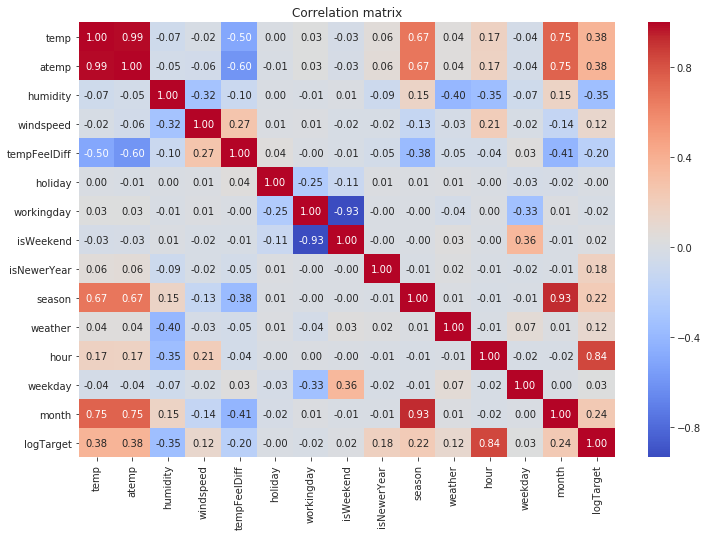

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = sns.heatmap(X_train_pre.assign(logTarget=y_train).corr(), annot=True, fmt=".2f", 
                 cmap="coolwarm", ax=ax)
ax.set_title('Correlation matrix')
plt.show()

# 8. Modeling

## 8.1. RMSE

We want to check the cross-validation result with a function that also will be scoring the final evaluations. In the case of this competition it is the Root Mean Squared Error with logarithmic transformation of the response.

In [34]:
def rmse(y, y_hat):
    mse = np.mean((y_hat - y) ** 2)
    return np.sqrt(mse)

rmse = make_scorer(rmse, greater_is_better=False)

## 8.2. Linear regression

Benchmark linear model. First we will drop highly correlated features and from every pair keep the one that is more strongly correlated to the target. At the end we will double check the multicollinearity with use of Variance Inflation Factor. 

In [35]:
X_train_lm = X_train_pre.drop(['atemp', 'month', 'isWeekend'], axis=1)
vif = VIFSelector(thresh=5.)
X_train_lm = vif.fit_transform(X_train_lm)

params = {'alpha': 10 ** np.linspace(-3, 1, 200)}

lmcv = GridSearchCV(Lasso(random_state=SEED), params, scoring=rmse, cv=5)
lmcv.fit(X_train_lm, y_train)

print('Best cross-validation score on the', Colours.blue('Ridge Regression'), 'is:', 
      np.round(abs(lmcv.best_score_), 2))

Best cross-validation score on the Ridge Regression is: 0.61


It gives us a certain point of reference according to which we will try to improve our result (I have also tried the Lasso in place of Ridge but the results were the same). The only thing that we will check for this model is whether its error follows normal distribution and which features turned out to be important.

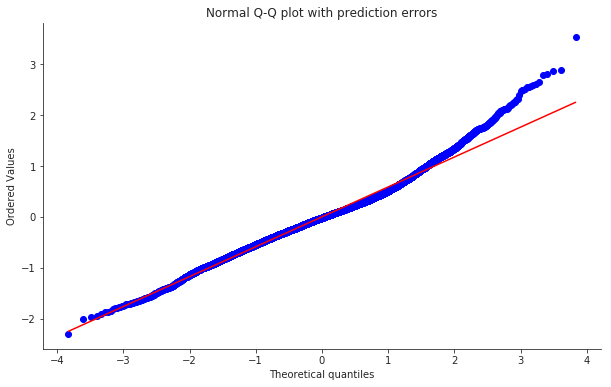

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = probplot(lmcv.predict(X_train_lm) - y_train, plot=sns.mpl.pyplot)
plt.title('Normal Q-Q plot with prediction errors')
sns.despine()
plt.show()

It was easy to predict that the time and year will be the strongest variables in this model. Shape of the learning curve was also awaited, clearly seen that this model is burdened with a large bias and small variance (closeness of cv and train curve). Parallel course when the training set is close to the actual one testifies to the low complexity of the model.

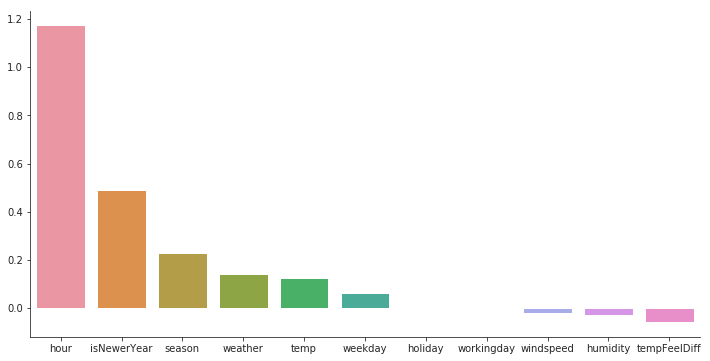

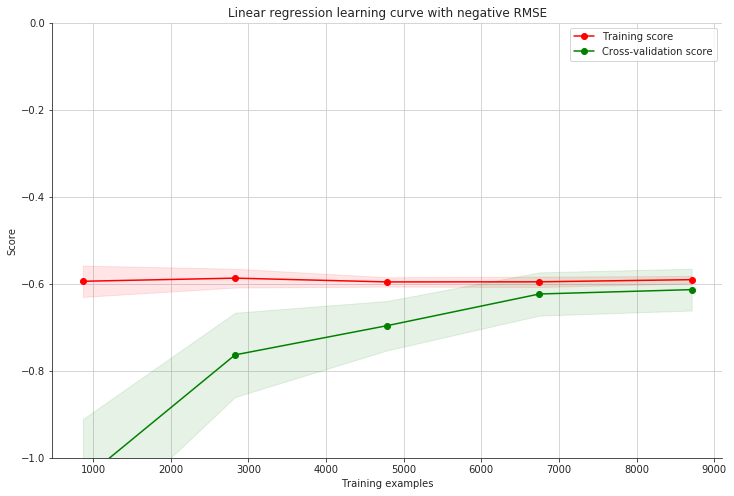

In [37]:
lm_coef = lmcv.best_estimator_.coef_
predictor_coef = list(zip(lm_coef, X_train_lm.columns.tolist()))
predictor_coef.sort(reverse=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x=[pair[1] for pair in predictor_coef], 
                 y=[pair[0] for pair in predictor_coef], 
                 label="Rigde regression coefficients",
                 ax=ax)
sns.despine()
plt.show()

plot_learning_curve(lmcv.best_estimator_, 'Linear regression learning curve with negative RMSE', 
                    X_train_lm, y_train, scoring=rmse, cv=5)
plt.ylim(-1, 0)
sns.despine()
plt.show()

## 8.3. Extra-Tree

In [38]:
def ext_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf,
           max_features, data, targets):
    """Extra-Tree cross validation.
    
    This function will instantiate an extra-tree regressor.
    
    Our goal is to find combinations of parameters that minimzes the RMSE.
    """
    estimator = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()


def optimize_ext(data, targets):
    """Apply Bayesian Optimization to Extra-Tree parameters."""
    def ext_crossval(n_estimators, max_depth, min_samples_split, 
                     min_samples_leaf, max_features):
        """Wrapper of Extra-Tree cross validation.
        """
        return ext_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max(min(max_features, .999), 1e-3),
            data=data,
            targets=targets,
        )

    ext_optimizer = BayesianOptimization(
        f=ext_crossval,
        pbounds={
            'n_estimators': (10, 500),
            'max_depth': (3, 10),
            'min_samples_split': (2, 100),
            'min_samples_leaf': (1, 10),
            'max_features': (.1, .999),
        },
        verbose=0,
        random_state=SEED
    )

#     # This calculations has been done in the cloud.
#     # Now I am only importing results, thus those lines are commented.
#     ext_logger = JSONLogger(path="./ext_logs.json")
#     ext_optimizer.subscribe(Events.OPTMIZATION_STEP, ext_logger)

    load_logs(ext_optimizer, logs=['./ext_logs.json'])
    print('Extra-Tree optimizer is now aware of {} points.\n'.format(len(ext_optimizer.space)))
    
    print(Colours.green('--- Optimizing Extra-Tree ---'))
    
    # init_points and n_iters need to be increased to search for hyperparams.
    ext_optimizer.maximize(init_points=0, n_iter=0, acq='ei', xi=0.0)

    best_params = ext_optimizer.max
    print(Colours.red('--- Final result ---'), '\n', best_params)
    
    return best_params

Extra-Tree optimizer is now aware of 125 points.

--- Optimizing Extra-Tree ---
--- Final result --- 
 {'target': -0.459685179820295, 'params': {'max_depth': 25.0, 'max_features': 0.999, 'min_samples_leaf': 1.0, 'min_samples_split': 7.010262347009907, 'n_estimators': 42.549067079149594}}


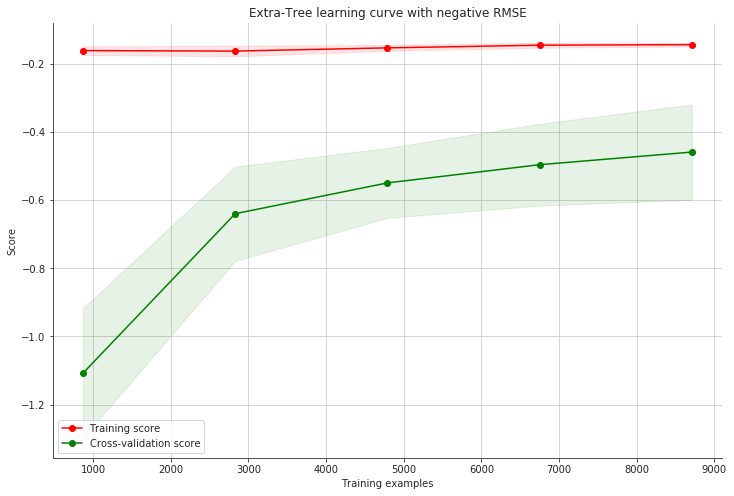

In [39]:
ext_params = optimize_ext(X_train_lm, y_train)['params']
ext_params.update({'random_state': SEED})
ext_params['max_depth'] = int(ext_params['max_depth'])
ext_params['n_estimators'] = int(ext_params['n_estimators'])
ext_params['min_samples_leaf'] = int(ext_params['min_samples_leaf'])
ext_params['min_samples_split'] = int(ext_params['min_samples_split'])

extre = ExtraTreesRegressor(**ext_params)
plot_learning_curve(extre, 'Extra-Tree learning curve with negative RMSE', 
                    X_train_lm, y_train, scoring=rmse, cv=5)
sns.despine()
plt.show()

Randomized tree regressor has beaten the linear model score but I still feal there is a lot to improve, especially judging by the prism of high variance among our ensemble tree model which could probably result in overfitting, so without further ado I will try to fit some significantly different model in terms of approach to construction (boosting). Another approach would be just to choose some less complicated model, for example simple DecisionTree or to choose less number of feature (especially try to reduce the noisy ones).

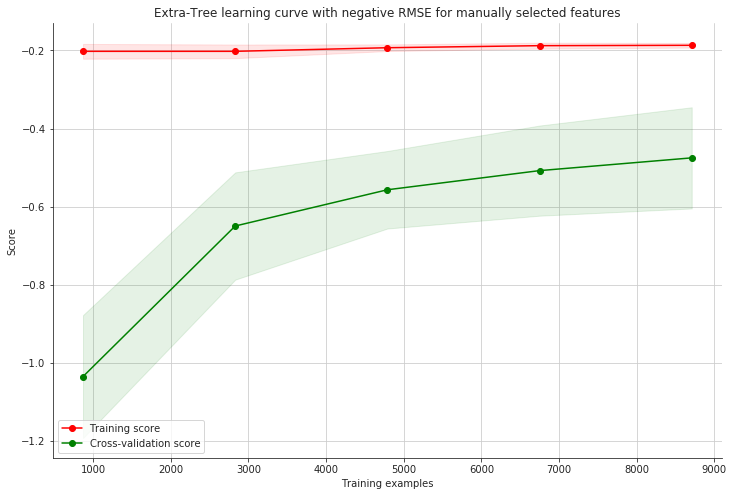

In [40]:
X_train_extre = X_train_lm[['hour', 'isNewerYear', 'season', 'weather', 'workingday', 'humidity', 'temp']]
plot_learning_curve(extre, 'Extra-Tree learning curve with negative RMSE for manually selected features', 
                    X_train_extre, y_train, scoring=rmse, cv=5)
sns.despine()
plt.show()

Ok, it helped nothing, so now I can skip to the next model.

## 8.4. XGBoost

Xgboost does not randomly use the correlated features in each tree, which random forest model suffers from such a situation, so we will not remove the highly correlated variables to maybe give some additional information. 

In [41]:
def optimize_xgb(data, targets):
    """XGBoost cross-validation.
    
    This function will instantiate a xgboost regressor.
    
    Our goal is to find combinations of parameters that minimzes the RMSE.
    """
    train_dmatrix = xgb.DMatrix(data=data, label=targets)

    def xgb_crossval(max_depth, min_child_weight, exp_eta, exp_gamma, 
                     exp_alpha, exp_lambda, subsample, colsample_bytree):
        """Wrapper of xgboost cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer. Also how we ensure max_depth is casted to integer 
        before we pass them along. Moreover, to avoid XXX
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        eta = 10 ** exp_eta
        gamma = 10 ** exp_gamma
        alpha = 10 ** exp_alpha
        lbd = 10 ** exp_lambda

        params = {
            'booster': 'gbtree',
            'silent': True,
            'eval_metric': 'rmse',
            'max_depth': int(max_depth),
            'min_child_weight': int(min_child_weight),
            'alpha': alpha,
            'lambda': lbd,
            'eta': eta,
            'gamma': gamma,
            'subsample': max(min(subsample, .999), 1e-3),
            'colsample_bytree': max(min(colsample_bytree, .999), 1e-3),
            'seed': SEED
        }

        cv_result = xgb.cv(dtrain=train_dmatrix, params=params, nfold=5,
                          num_boost_round=500, early_stopping_rounds=50, 
                          metrics='rmse', as_pandas=True, seed=SEED)

        return -1.0 * cv_result['test-rmse-mean'].iloc[-1]


    xgb_optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            'max_depth': (3, 10),
            'min_child_weight': (1, 15),
            'exp_alpha': (-5., 2.),
            'exp_lambda': (-2., 2.),
            'exp_eta': (-2., -.5),
            'exp_gamma': (-2., 2.),
            'subsample': (.4, 1.),
            'colsample_bytree': (.2, 1.)
        },
        verbose=2,
        random_state=SEED
    )
    
    # xgb_logger = JSONLogger(path="./xgb_logs.json")
    # xgb_optimizer.subscribe(Events.OPTMIZATION_STEP, xgb_logger)
    
    load_logs(xgb_optimizer, logs=['./xgb_logs.json'])
    print('XGBoost optimizer is now aware of {} points.\n'.format(len(xgb_optimizer.space)))
    
    print(Colours.green('--- Optimizing XGB Regression ---'))
    xgb_optimizer.maximize(init_points=0, n_iter=0, acq='ei', xi=0.0)

    best_params = xgb_optimizer.max
    print(Colours.red('--- Final result ---'), '\n', best_params)

    return best_params

Select best parameters and project them onto the correct types.

In [42]:
xgb_params = optimize_xgb(X_train_pre, y_train)['params']

base_xgb_params = {
    'booster': 'gbtree',
    'silent': True,
    'eval_metric': 'rmse',
    'seed': SEED
}

xgb_params.update(base_xgb_params)

for param in [param for param in xgb_params if param.find('exp_') > -1]:
    xgb_params[param.replace('exp_', '')] = 10 ** xgb_params[param]
    xgb_params.pop(param, None)

xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['min_child_weight'] = int(xgb_params['min_child_weight'])

XGBoost optimizer is now aware of 300 points.

--- Optimizing XGB Regression ---
|   iter    |  target   | colsam... | exp_alpha |  exp_eta  | exp_gamma | exp_la... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
--- Final result --- 
 {'target': -0.3138992, 'params': {'colsample_bytree': 0.9898433872684396, 'exp_alpha': -0.38096389492228777, 'exp_eta': -1.5747667191409462, 'exp_gamma': -1.1237278705590636, 'exp_lambda': 0.652920039568591, 'max_depth': 9.548373867357132, 'min_child_weight': 8.992307171748472, 'subsample': 0.8757978789388117}}


Let's investigate the learning curve of this regressor. We can see that the score on the sklearn implementation of cross-validation differs from the xgboost cv and is much closer to the obtained result. 

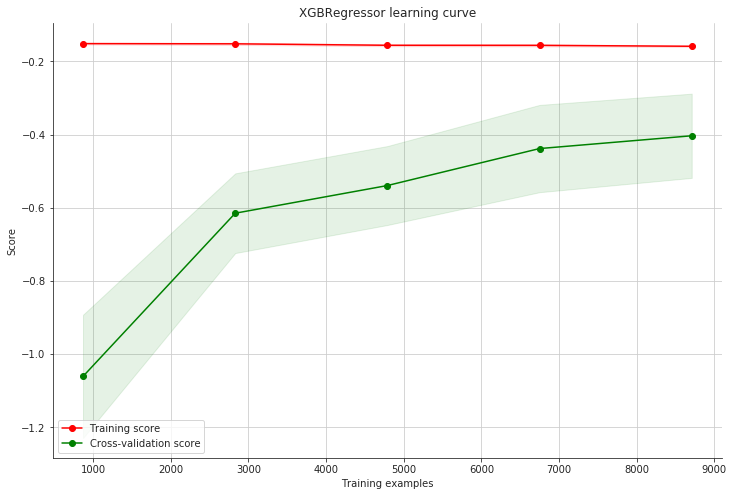

In [43]:
sklearn_params = xgb_params.copy()
sklearn_params['learning_rate'] = sklearn_params.pop('eta')
sklearn_params['random_state'] = sklearn_params.pop('seed')
sklearn_params['reg_lambda'] = sklearn_params.pop('lambda')
sklearn_params['reg_alpha'] = sklearn_params.pop('alpha')
xgb_metric = sklearn_params.pop('eval_metric')

xgb_sklearn = XGBRegressor(n_estimators=500, **sklearn_params)
plot_learning_curve(xgb_sklearn, 'XGBRegressor learning curve', X_train_pre, y_train, 
                    cv=5, scoring=rmse, random_state=SEED)
sns.despine()
plt.show()

### 8.4.1. Training

Firstly let's check how many boosting rounds is necessary.

In [44]:
train_dmatrix = xgb.DMatrix(data=X_train_pre, label=y_train)

cv_result = xgb.cv(dtrain=train_dmatrix, params=xgb_params, nfold=5,
                  num_boost_round=500, early_stopping_rounds=50, 
                  metrics='rmse', as_pandas=True, seed=SEED)

cv_result.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
495,0.159885,0.000957,0.313938,0.010307
496,0.159766,0.000955,0.313904,0.010320
497,0.159663,0.000972,0.313911,0.010314
498,0.159551,0.000926,0.313901,0.010322
499,0.159462,0.000923,0.313899,0.010329


Now we can train the model.

In [45]:
train_dmatrix = xgb.DMatrix(data=X_train_pre, label=y_train)
xgb_model = xgb.train(params=xgb_params, dtrain=train_dmatrix, num_boost_round=500)

# 9. Interpretation

### TOP5
#### Hour
1. The most frequent variable when making decision tree splitting.
2. Points to trends in renting bikes at specific times of the day.
3. It was shown earlier that it is most likely connected with commuting.
4. Rental peaks reached at 8 and 17-19.

#### Weekday
1. Explains the rental increases at the end of the week, when people start spending more time actively.
2. Gives a signal that Sunday is less popular among cyclists.

#### Month
1. Highly correlated with the season thus it can be added up because it points to the almost same phenomenon.
2. Winter months are enjoying little popularity of cycling in contrast to summer.

#### Humidity
1. Wet weather favors clothes getting dirty.
2. When we know that the most common recipient of bicycles are people commuting to work, additionally it explains the unwillingness to stain the work outfit.

#### Weather
1. The uglier, the rainier the weather, the less people on bicycles.

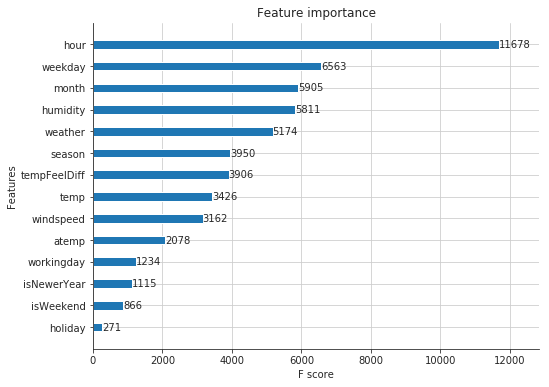

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = xgb.plot_importance(xgb_model, max_num_features=50, height=0.4, ax=ax)
sns.despine()
plt.show()

**NOTE:** This is only a rough analysis of the impact of variables. To properly examine the local impact of variables on predictions SHAP/LIME/Ceteris paribus analysis should be conducted. 

# 10. Prediction

In [47]:
X_test_pre = pd.DataFrame(preprocess_pipeline.transform(X_test), columns=column_names)
test_dmatrix = xgb.DMatrix(data=X_test_pre)
y_pred = xgb_model.predict(test_dmatrix)
y_real_pred = np.exp(y_pred) - 1

submission_datetime = pd.read_csv('test.csv')['datetime']
submission = pd.DataFrame({'datetime': submission_datetime, 'count': y_real_pred})
submission.to_csv('submission.csv', index=False)

# 11. Best model

This parameters were found by accident when I was checking the first results obtained from bayesian optimization with xgboost and it turned out to be the best submission I have manage to commit (0.42965 RMSLE).

In [48]:
top_params = {
    'booster': 'gbtree',
    'silent': True,
    'eval_metric': 'rmse',
    'max_depth': 6,
    'min_child_weight': 3,
    'alpha': 0,
    'lambda': 10 ** -0.4257,
    'eta': 10 ** -1.817,
    'gamma': 10 ** -0.783,
    'subsample': 0.7671,
    'colsample_bytree': 0.5091,
    'seed': SEED
}

model = xgb.train(params=top_params, dtrain=train_dmatrix, num_boost_round=3000)

y_pred = model.predict(test_dmatrix)
y_real_pred = np.exp(y_pred) - 1

submission['count'] = y_real_pred
submission.to_csv('best_submission.csv', index=False)

# 12. Room for improvement

* Various ways of coding categorical variables can be tried, my recommendation: one-hot or frequency encoding first.
* Gradient boosting on reimplemented cross-validation with use of sklearn package (results actually closer to the obtained ones).
* Gradient boosting hyperparameter tuning on a larger number of the following trees.
* Trying solutions that are not based on decision trees (for example: SVR).
* Averaging well-performing models with the least correlated predictions.
* Averaging gradient boosting results achieved on a different seeds.